1. 대화를 끊어서 입력한 이유
대화 전체를 한번에 back-translation 하거나 paraphrase 하는 것은 성능이 매우 안좋은 것을 관찰할 수 있었음 이에 train데이터가 줄바꿈을 기준으로 대화를 나눌 수 있기에 줄바꿈을 기준으로 한줄씩 입력하자 정성적으로 평가하였을때 훨씬 나은 모습을 보였음.
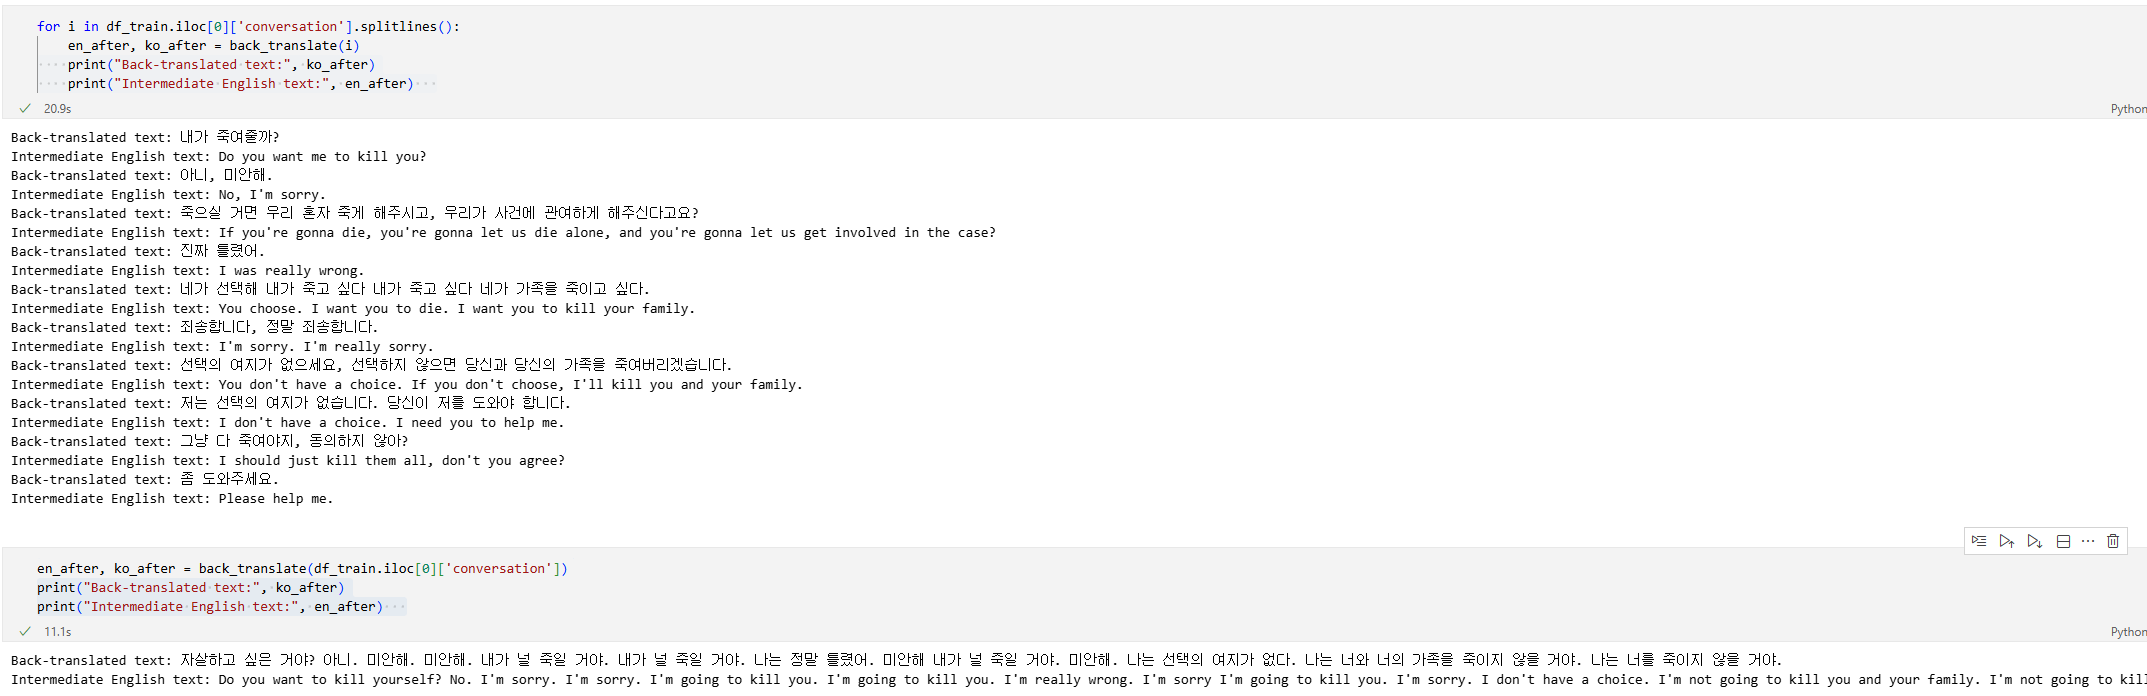
2. 노이즈 기반 증강 (Noise Injection)을 하지 않은 이유
데이터를 확인하여 보았을때 문자의 형식이 아닌 일상생활에서 말한 것을 대본 처럼 받아쓴 것 처럼 보이기에 적절하지 않은 증강방법이라고 생각하여 제외하였음.
3. 합성데이터는 줄바꿈이 없는 데이터 이므로 임의로 전처리를 추가하여 데이터를 처리하였음


In [1]:
import pandas as pd
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

df_train = pd.read_csv('data/train.csv')
df_general = pd.read_csv('data/general_data.txt', sep=',', encoding='utf-8')

print("Train data shape:", len(df_train))
print(df_train.head())

print("General data shape:", len(df_general))
print(df_general.head())

df = pd.concat([df_train, df_general], ignore_index=True)
print("Merged data shape:", len(df))
print(df.head())

Train data shape: 3950
   idx      class                                       conversation
0    0      협박 대화  지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1    1      협박 대화  길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2    2  기타 괴롭힘 대화  너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3    3      갈취 대화  어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4    4      갈취 대화  저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...
General data shape: 800
   idx class                                       conversation
0    0    일반  오늘 날씨 진짜 좋다. 그치? 하늘도 맑고. 응, 어디 놀러 가고 싶어지네. 주말에...
1    1    일반  점심 뭐 먹을래? 글쎄... 어제 치킨 먹어서 오늘은 좀 담백한 거. 그럼 파스타 ...
2    2    일반  요즘 뭐 재미있는 드라마 있어? 아, 나 새로 시작한 거 있는데 완전 내 스타일이야...
3    3    일반  주말에 뭐 했어? 친구 만나서 영화 봤어. 너는? 나는 집에서 뒹굴뒹굴. ㅋㅋ 그게...
4    4    일반  퇴근하고 뭐 해? 바로 집에 가지. 피곤해서... 그치, 나도. 집에 가서 저녁 먹...
Merged data shape: 4750
   idx      class                                       conversation
0    0      협박 대화  지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 

## Back traslation ##

In [4]:

from tqdm import tqdm
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM, MarianTokenizer, MarianMTModel, M2M100ForConditionalGeneration, AutoModelForSeq2SeqLM, AutoTokenizer, AutoModel, T5Model

src_t = MarianTokenizer.from_pretrained('Helsinki-NLP/opus-mt-ko-en') 
src_m = MarianMTModel.from_pretrained('Helsinki-NLP/opus-mt-ko-en') 
tgt_t = AutoTokenizer.from_pretrained('NHNDQ/nllb-finetuned-en2ko') 
tgt_m = M2M100ForConditionalGeneration.from_pretrained('NHNDQ/nllb-finetuned-en2ko')

c:\Users\tkdwl\miniconda3\envs\aiffel\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\tkdwl\miniconda3\envs\aiffel\Lib\site-packages\transformers\models\marian\tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [5]:
def back_translate(text):
    # ko->en
    tokenized = src_t(text, return_tensors="pt", truncation=True)
    en = src_m.generate(**tokenized, num_beams=5, do_sample=False)
    en_text = src_t.batch_decode(en, skip_special_tokens=True)[0]
    # en->ko
    tokenized2 = tgt_t(en_text, return_tensors="pt", truncation=True)
    ko = tgt_m.generate(**tokenized2, num_beams=5, do_sample=False)
    ko_text = tgt_t.batch_decode(ko, skip_special_tokens=True)[0]
    return en_text, ko_text

In [ ]:
for i in df_train.iloc[0]['conversation'].splitlines():
    en_after, ko_after = back_translate(i)
    print("Back-translated text:", ko_after)
    print("Intermediate English text:", en_after)   

Back-translated text: 내가 죽여줄까?
Intermediate English text: Do you want me to kill you?
Back-translated text: 아니, 미안해.
Intermediate English text: No, I'm sorry.
Back-translated text: 죽으실 거면 우리 혼자 죽게 해주시고, 우리가 사건에 관여하게 해주신다고요?
Intermediate English text: If you're gonna die, you're gonna let us die alone, and you're gonna let us get involved in the case?
Back-translated text: 진짜 틀렸어.
Intermediate English text: I was really wrong.
Back-translated text: 네가 선택해 내가 죽고 싶다 내가 죽고 싶다 네가 가족을 죽이고 싶다.
Intermediate English text: You choose. I want you to die. I want you to kill your family.
Back-translated text: 죄송합니다, 정말 죄송합니다.
Intermediate English text: I'm sorry. I'm really sorry.
Back-translated text: 선택의 여지가 없으세요, 선택하지 않으면 당신과 당신의 가족을 죽여버리겠습니다.
Intermediate English text: You don't have a choice. If you don't choose, I'll kill you and your family.
Back-translated text: 저는 선택의 여지가 없습니다. 당신이 저를 도와야 합니다.
Intermediate English text: I don't have a choice. I need you to help me.
Back-translated text: 그냥

In [ ]:
en_after, ko_after = back_translate(df_train.iloc[0]['conversation'])
print("Back-translated text:", ko_after)
print("Intermediate English text:", en_after)   

Back-translated text: 자살하고 싶은 거야? 아니. 미안해. 미안해. 내가 널 죽일 거야. 내가 널 죽일 거야. 나는 정말 틀렸어. 미안해 내가 널 죽일 거야. 미안해. 나는 선택의 여지가 없다. 나는 너와 너의 가족을 죽이지 않을 거야. 나는 너를 죽이지 않을 거야.
Intermediate English text: Do you want to kill yourself? No. I'm sorry. I'm sorry. I'm going to kill you. I'm going to kill you. I'm really wrong. I'm sorry I'm going to kill you. I'm sorry. I don't have a choice. I'm not going to kill you and your family. I'm not going to kill you.


: 

## Paraphrase ##

In [7]:
from transformers import T5ForConditionalGeneration

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = T5ForConditionalGeneration.from_pretrained('lcw99/t5-base-korean-paraphrase').to(device)
tokenizer = AutoTokenizer.from_pretrained('lcw99/t5-base-korean-paraphrase')

sentence = "7층 방문을 위해 방문록 작성이 필요합니다."
text =  f"paraphrase: {sentence} "

encoding = tokenizer.batch_encode_plus(
            [text],
            max_length=256,
            truncation=True,
            padding="max_length",
            return_tensors="pt",)

source_ids = encoding["input_ids"].to(device, dtype=torch.long)
source_mask = encoding["attention_mask"].to(device, dtype=torch.long)

generated_ids = model.generate(
                input_ids=source_ids,
                attention_mask=source_mask,
                max_length=150,
                num_beams=2,
                repetition_penalty=2.5,
                length_penalty=1.0,
                early_stopping=True)

preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]

def paraphrase(text):
    text =  f"paraphrase: {text} "

    encoding = tokenizer.batch_encode_plus(
                [text],
                max_length=256,
                truncation=True,
                padding="max_length",
                return_tensors="pt",)

    source_ids = encoding["input_ids"].to(device, dtype=torch.long)
    source_mask = encoding["attention_mask"].to(device, dtype=torch.long)

    generated_ids = model.generate(
                    input_ids=source_ids,
                    attention_mask=source_mask,
                    max_length=150,
                    num_beams=2,
                    repetition_penalty=2.5,
                    length_penalty=1.0,
                    early_stopping=True)

    preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
    return preds[0]

print(f"Original Sentence :: {sentence}")
print(f"Paraphrased Sentence :: {paraphrase(sentence)}")

Original Sentence :: 7층 방문을 위해 방문록 작성이 필요합니다.
Paraphrased Sentence :: 7층을 방문하기 위해서는 방문록을 작성해야 합니다.


In [9]:
for i in df_train.iloc[-3]['conversation'].splitlines():
    after = paraphrase(i)
    print("Original text:", i)
    print("Paraphrased text:", after)
    

Original text: 나는 씨 같은 사람 보면 참 신기하더라. 어떻게 저렇게 살지.
Paraphrased text: 씨는 어떻게 저렇게 삶을 사는 건지 참 궁금하다.
Original text: 왜 그래. 들리겠어.
Paraphrased text: 왜 그래? 안 들을 이유가 없는데.
Original text: 들리라고 해. 아니 일 못해 눈치 없어. 본인도 슬슬 깨달아야 되지 않나?
Paraphrased text: 아니 일 안 하니까 눈치 보여? 자기도 할 수 있는 거 아닌가 몰라?
Original text: 하긴 그래서 저번에 부장님도.
Paraphrased text: 하긴 그래서 부장님도 저번에 한번 그렇게 하시죠.
Original text: 그렇다니깐! 부장님이 진짜 착하신 분인데 오죽 답답했으면 말을 했겠어?
Paraphrased text: 정말 답답하니까 말을 부장님이 못 들을 정도로 했네.
Original text: 그러게.
Paraphrased text: 응 그래 우리는 반티가 없었죠
Original text: 회사생활 같이 한게 몇년인데 대답 하나 제대로 네 하고 싹싹하게 하는걸 못봤어.
Paraphrased text: 회사 생활을 몇 년 동안 했는데도 네 대답 하나 제대로 안 하고 무뚝뚝하게 하는 걸 봤어.
Original text: 나도 그건 못본거 같다.
Paraphrased text: 나도 그런 건 본 적이 없어.
Original text: 지금도 그래. 야 야! 너 바로 앞에서 얘기하는데 귀가 먹어서 안들리는거니 안들리는척 하는거니? 뭐 말 좀 해봐?
Paraphrased text: 지금도 너 귀 기울여서 뭐라 하는데 사실은 뭐가 뭔지 모르겠어.
Original text: 야 너 왜 그래.
Paraphrased text: 야 너 왜 이렇게 늦게 들어왔어?
Original text: 말씀이 너무 심하신거 아니에요?
Paraphrased text: 너무 심한 말을 하신 거 아니에요?


## 문자 위치 변경(순서 섞기) + 문자 대치(치환) ##

중단 유의어 사전 만들기에는 시간이 너무 촉박함

In [ ]:
from konlpy.tag import Okt
import random
import re

okt = Okt()

# ─────────────────────────────────────────────────────────
# 1) 유의어 사전 (구어체 위주, 필요하면 계속 추가)
#    키가 포함된 어절 전체를 치환함(대소문자 무시X, 한국어라 괜찮음)
SYNONYMS = {
    "진짜": ["정말", "진심", "참"],
    "진심": ["진짜", "진정", "정말"],
    "너무": ["엄청", "되게", "꽤"],
    "엄청": ["정말", "꽤", "상당히"],
    "완전": ["진짜", "정말", "진짜로"],
    "좀":   ["조금", "쪼끔", "살짝"],
    "조금": ["좀", "살짝", "약간"],
    "빨리": ["서둘러", "얼른", "후딱"],
    "화남": ["열받음", "빡침", "화남ㅠ"],
    "화나": ["열받아", "빡쳐", "짜증나"],
    "괜찮아": ["오케이", "좋아", "문제없어"],
    "고마워": ["감사", "고맙다", "땡큐"],
    "미안": ["미안해", "쏘리", "미안혀"],
    "왜": ["어째서", "무슨 이유로"],
    "지금": ["방금", "지금당장", "바로"],
    "약속": ["약조", "약속건", "약속사항"],  # 필요시 삭제/수정
}

# ─────────────────────────────────────────────────────────
# 2) 섞어도 괜찮은 어절 판별: 콘텐츠 중심(Noun/Adverb) 위주
CONTENT_POS = {"Noun", "Adverb", "Alpha", "Number"}
FORBID_POS  = {"Josa", "Eomi", "PreEomi", "Punctuation", "Suffix", "Determiner", "Conjunction"}
END_PUNCS   = set(".,!?…~」』)〉》]}，．？！")

def is_swappable_eojeol(eojeol: str) -> bool:
    """조사/어미 위주 어절은 이동 금지. 콘텐츠 품사가 있는 어절만 허용."""
    if not eojeol.strip():
        return False
    if eojeol[-1] in END_PUNCS:
        return False
    pos = okt.pos(eojeol, stem=False, norm=False)
    # 콘텐츠 품사가 1개 이상 있고, 금지 품사로만 구성되지 않은 경우
    has_content = any(p in CONTENT_POS for _, p in pos)
    only_forbid = all(p in FORBID_POS for _, p in pos)
    # 동사/형용사(Verb/Adjective) 어절은 어미가 붙어 형태가 많이 변하므로 기본은 제외
    has_verb_adj = any(p in {"Verb", "Adjective"} for _, p in pos)
    return has_content and not only_forbid and not has_verb_adj

# ─────────────────────────────────────────────────────────
# 3) 어절 위치 국소 섞기: 윈도우 내에서만 스왑(자연스러움 유지)
def local_shuffle_by_space(text: str, ratio: float = 0.2, window: int = 2, seed: int = None) -> str:
    """
    ratio: 섞을 대상 어절 비율(0.2 = 20%)
    window: 좌우 몇 칸 이내에서만 스왑 (문맥 파괴 방지)
    """
    if seed is not None:
        random.seed(seed)

    eojeols = text.split()  # 띄어쓰기 단위
    if len(eojeols) < 3:
        return text

    swappable_idxs = [i for i, e in enumerate(eojeols) if is_swappable_eojeol(e)]
    if not swappable_idxs:
        return text

    n_swap = max(1, int(len(swappable_idxs) * ratio))
    chosen = random.sample(swappable_idxs, min(n_swap, len(swappable_idxs)))
    used = set()

    for idx in chosen:
        if idx in used:
            continue
        # 같은 윈도우 내의 다른 swappable 대상 찾기
        cand_range = [j for j in range(max(0, idx - window), min(len(eojeols), idx + window + 1)) if j != idx]
        cand_range = [j for j in cand_range if j in swappable_idxs and j not in used]
        if not cand_range:
            continue
        j = random.choice(cand_range)
        eojeols[idx], eojeols[j] = eojeols[j], eojeols[idx]
        used.add(idx); used.add(j)

    return " ".join(eojeols)

# ─────────────────────────────────────────────────────────
# 4) 유의어 치환: 콘텐츠 어절만 확률적으로 교체
def replace_synonyms_by_space(text: str, prob: float = 0.25, seed: int = None) -> str:
    if seed is not None:
        random.seed(seed)

    eojeols = text.split()
    out = []
    for e in eojeols:
        if not e.strip():
            out.append(e); continue

        # 콘텐츠 어절만 치환
        if is_swappable_eojeol(e) and random.random() < prob:
            # 완전 일치 키 먼저
            if e in SYNONYMS:
                out.append(random.choice(SYNONYMS[e]))
                continue
            # 어절 내 부분 일치(예: "진짜로"에 "진짜" 포함)
            replaced = False
            for key, cands in SYNONYMS.items():
                if key in e:
                    out.append(e.replace(key, random.choice(cands)))
                    replaced = True
                    break
            if replaced:
                continue
        out.append(e)

    return " ".join(out)

# ─────────────────────────────────────────────────────────
# 5) 종합 증강: (1) 국소 섞기 → (2) 유의어 치환  (순서 바꿔도 됨)
def colloquial_augment(text: str,
                       shuffle_ratio: float = 0.2,
                       shuffle_window: int = 2,
                       synonym_prob: float = 0.25,
                       seed: int = None) -> str:
    t = local_shuffle_by_space(text, ratio=shuffle_ratio, window=shuffle_window, seed=seed)
    t = replace_synonyms_by_space(t, prob=synonym_prob, seed=seed)
    return t

# ─────────────────────────────────────────────────────────
# 사용 예시
if __name__ == "__main__":
    s = "오늘 회의 끝나고 자료 좀 빨리 보내줄 수 있어? 진짜 급해."
    print("원문 :", s)
    print("섞기 :", local_shuffle_by_space(s, ratio=0.3, window=2, seed=42))
    print("유의어:", replace_synonyms_by_space(s, prob=0.5, seed=42))
    print("종합 :", colloquial_augment(s, shuffle_ratio=0.25, shuffle_window=2, synonym_prob=0.4, seed=42))